In [1]:
import plotly.io as pio
pio.renderers.default = "iframe_connected"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

from transformers import pipeline
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_combined = pd.read_csv("../aggregated_data/combined_review_data_with_sentiment.csv")


In [ ]:
# Define food delivery app-specific labels for different sentiment categories
negative_labels = [
    "late delivery", "cold food", "missing items", "high fees", "incorrect order",
    "unresponsive customer service", "app crashes", "canceled order", "payment issues",
    "driver issues", "tracking problems", "refund problems", "bad packaging",
    "order never arrived", "overpriced", "poor restaurant selection", "damaged items",
    "long wait times", "hygiene concerns", "expired promotions", "account issues"
]

positive_labels = [
    "fast delivery", "good customer service", "accurate order", "food quality",
    "reasonable prices", "wide restaurant selection", "easy to use", "helpful tracking",
    "good discounts", "reliable service", "friendly drivers", "good packaging",
    "order accuracy", "quick refunds", "accommodating special requests",
    "subscription benefits", "contactless delivery", "transparent pricing"
]

neutral_labels = [
    "average delivery time", "expected service", "minor issues", "feature suggestions",
    "mixed experiences", "inconsistent service", "new app version", "occasional delays",
    "typical for delivery apps", "standard packaging", "common delivery experience",
    "reasonable for price point", "depends on restaurant", "driver tipping feedback"
]

In [ ]:
# Initialize the zero-shot classification pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [ ]:
def classify_reviews(reviews, labels, batch_size=16, pbar=None):
    results = []
    for i in range(0, len(reviews), batch_size):
        batch = reviews[i:i+batch_size]
        batch_results = classifier(batch, labels, multi_label=True)
        results.extend(batch_results)

        # Update progress bar for each batch processed
        if pbar:
            pbar.update(len(batch))  # Update for each batch

    return results


In [ ]:
def process_sentiment(df, sentiment_value, labels):
    # Filter reviews by sentiment
    sentiment_df = df[df['sentiment'] == sentiment_value]

    results_by_app = {}

    # Group by app_name
    for app_name in sentiment_df['app_name'].unique():
        app_reviews = sentiment_df[sentiment_df['app_name'] == app_name]

        if len(app_reviews) < 5:
            continue

        # Get review texts
        reviews = app_reviews['review'].tolist()

        # Apply zero-shot classification
        results = []
        with tqdm(total=len(reviews), desc=f"{sentiment_value} - {app_name}") as pbar:
            results = classify_reviews(reviews, labels, pbar=pbar)  # Pass progress bar here

        # Extract top label for each review
        top_labels = [result['labels'][0] for result in results]
        top_scores = [result['scores'][0] for result in results]

        # Add results to the dataframe
        app_reviews = app_reviews.copy()
        app_reviews['top_label'] = top_labels
        app_reviews['top_score'] = top_scores

        # Store for visualization
        results_by_app[app_name] = app_reviews

    return results_by_app


In [ ]:
negative_results = process_sentiment(df_combined, 'Negative', negative_labels)

In [ ]:
negative_results_df = pd.concat(negative_results.values(), ignore_index=True)

In [ ]:
negative_results_df.to_csv('negative_results.csv', index=False)

In [ ]:
neutral_results = process_sentiment(df_combined, 'Neutral', neutral_labels)

In [ ]:
neutral_results_df = pd.concat(neutral_results.values(), ignore_index=True)

In [ ]:
neutral_results_df.to_csv('neutral_results.csv', index=False)

In [ ]:

positive_results = process_sentiment(df_combined, 'Positive', positive_labels)

In [ ]:
positive_results_df = pd.concat(positive_results.values(), ignore_index=True)

In [ ]:
positive_results_df.to_csv('positive_results.csv', index=False)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px


In [4]:
negative_df = pd.read_csv('../data/Zero_Shot_Classification/negative_results.csv')
neutral_df = pd.read_csv('../data/Zero_Shot_Classification/neutral_results.csv')
positive_df = pd.read_csv('../data/Zero_Shot_Classification/positive_results.csv')


In [5]:
combined_df = pd.concat([negative_df, neutral_df, positive_df], axis=0, ignore_index=True)

## Top 5 Labels for Positive Sentiment

In [6]:
top_label_counts = combined_df.groupby(['sentiment', 'top_label']).size().reset_index(name='count')

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\2217802626.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




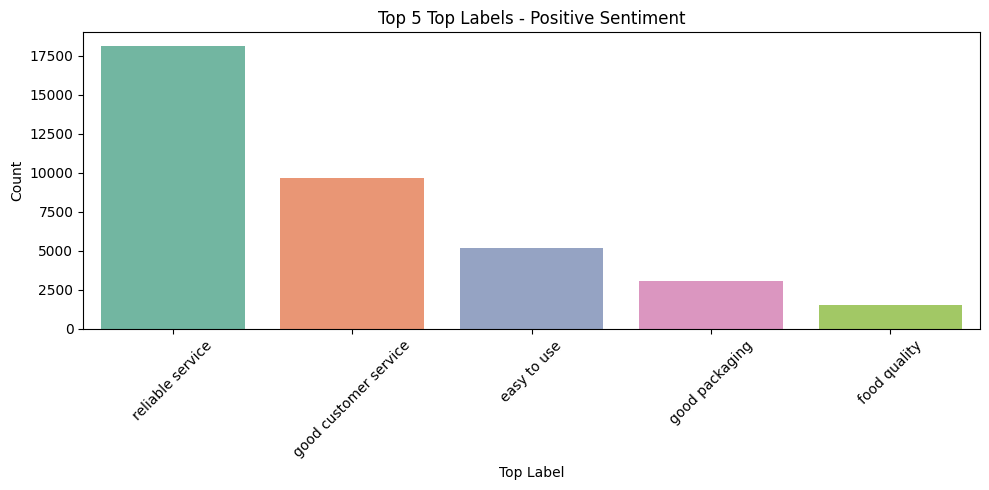

In [7]:

#| echo: true
# Filter for positive sentiment (case-insensitive correction if needed)
positive_labels = top_label_counts[top_label_counts['sentiment'].str.lower() == 'positive']

# Get top 5 labels sorted by count
positive_top5 = positive_labels.sort_values(by='count', ascending=False).head(5)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(x='top_label', y='count', data=positive_top5, palette="Set2")
plt.title('Top 5 Top Labels - Positive Sentiment')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Reliable service" stands out as the most frequently praised feature.
Customer service and ease of use follow as other key drivers of positive sentiment.

##  Top 5 Labels for Negative Sentiment

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\3209300340.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




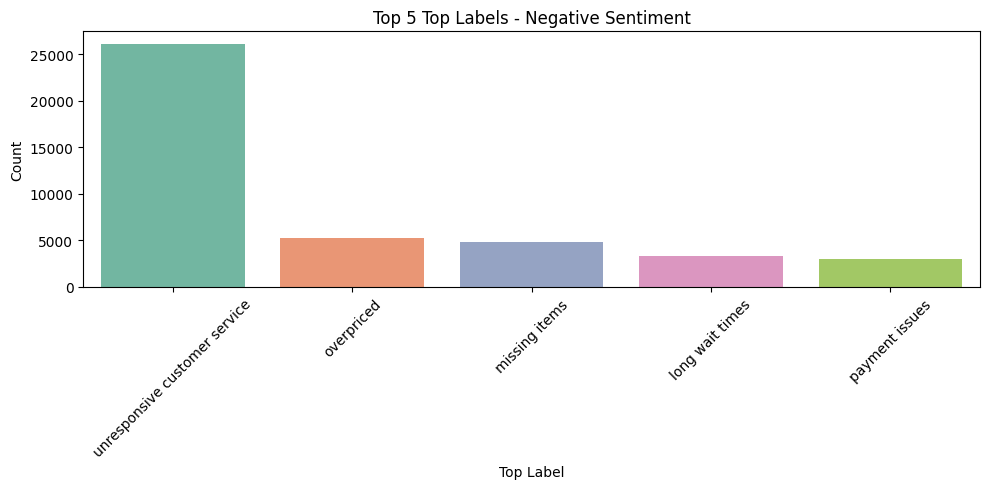

In [8]:
#| echo: true
# Negative sentiment
negative_labels = top_label_counts[top_label_counts['sentiment'].str.lower() == 'negative']
negative_top5 = negative_labels.sort_values(by='count', ascending=False).head(5)

plt.figure(figsize=(10,5))
sns.barplot(x='top_label', y='count', data=negative_top5, palette="Set2")
plt.title('Top 5 Top Labels - Negative Sentiment')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Unresponsive customer service" dominates negative feedback.
Price-related concerns and delivery issues (missing items, wait times) are also significant.

##  Top 5 Labels for Neutral Sentiment

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\200243279.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




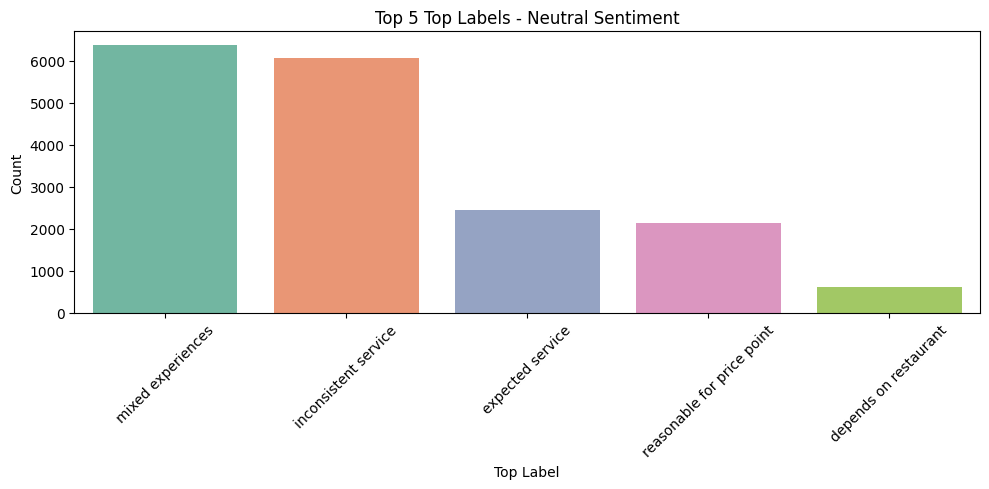

In [9]:
#| echo: true
# Neutral sentiment
neutral_labels = top_label_counts[top_label_counts['sentiment'].str.lower() == 'neutral']
neutral_top5 = neutral_labels.sort_values(by='count', ascending=False).head(5)

plt.figure(figsize=(10,5))
sns.barplot(x='top_label', y='count', data=neutral_top5, palette="Set2")
plt.title('Top 5 Top Labels - Neutral Sentiment')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Feedback reflects variability, with "mixed experiences" and "inconsistent service" being most mentioned.
Neutral sentiments often reflect tempered expectations or situational outcomes.

## UberEats - Top 5 Labels for Positive Sentiments

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\3373619653.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




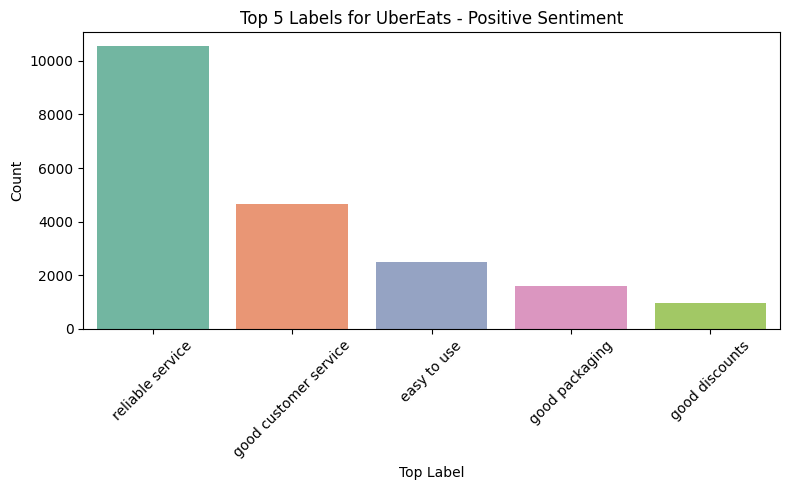

In [10]:
#| echo: true
# Filter UberEats reviews
ubereats = combined_df[combined_df['app_name'] == 'UberEats']

# Filter Positive sentiment
positive_df = ubereats[ubereats['sentiment'].str.lower() == 'positive']

# Top 5 labels
positive_top5 = positive_df['top_label'].value_counts().head(5)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=positive_top5.index, y=positive_top5.values, palette='Set2')
plt.title('Top 5 Labels for UberEats - Positive Sentiment')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


UberEats is positively recognized for reliable service and good customer support.
"Good discounts" also appear, showing promotional offers impact user satisfaction.

## UberEats - Top 5 Labels for Negative Sentiments

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\719617373.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




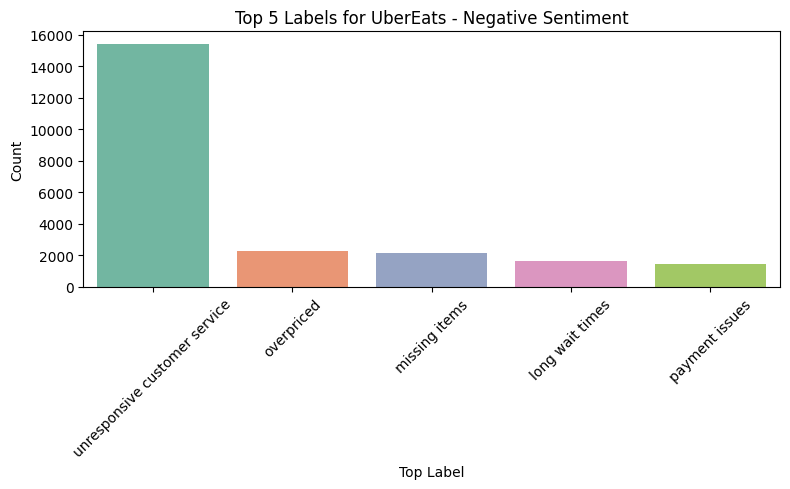

In [11]:
#| echo: true
# Filter Negative sentiment
negative_df = ubereats[ubereats['sentiment'].str.lower() == 'negative']

# Top 5 labels
negative_top5 = negative_df['top_label'].value_counts().head(5)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=negative_top5.index, y=negative_top5.values, palette='Set2')
plt.title('Top 5 Labels for UberEats - Negative Sentiment')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


"Unresponsive customer service" is the top concern among UberEats users.
Other recurring complaints include pricing and delivery fulfillment issues.

## UberEats - Top 5 Labels for Neutral Sentiments

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\3615030921.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




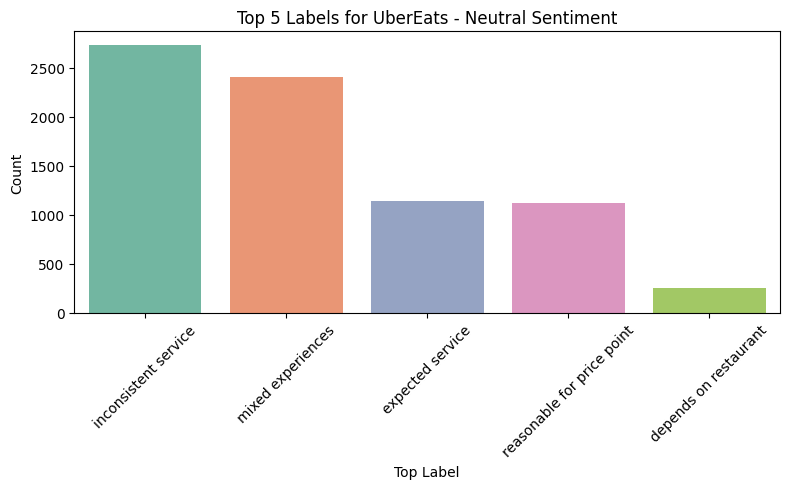

In [12]:
# Filter Neutral sentiment
#| echo: true
neutral_df = ubereats[ubereats['sentiment'].str.lower() == 'neutral']

# Top 5 labels
neutral_top5 = neutral_df['top_label'].value_counts().head(5)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=neutral_top5.index, y=neutral_top5.values, palette='Set2')
plt.title('Top 5 Labels for UberEats - Neutral Sentiment')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


"Inconsistent service" and "mixed experiences" dominate the neutral feedback for UberEats.
Sentiment here indicates fluctuating user experiences without strong positive or negative lean.

## UberEats - Interactive Top 5 Labels

In [13]:
#| echo: true
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Prepare unique combinations
data_sources = ['Google Play', 'Reddit', 'App Store']
sentiments = ['Positive', 'Neutral', 'Negative']

# Store traces and buttons
fig = go.Figure()
buttons = []
visibility = []

# Track trace index
trace_idx = 0

for data_source in data_sources:
    for sentiment in sentiments:
        source_df = ubereats[ubereats['data_source'] == data_source]
        source_sentiment_df = source_df[source_df['sentiment'] == sentiment]
        top5_labels = source_sentiment_df['top_label'].value_counts().head(5)

        if not top5_labels.empty:
            trace = go.Bar(
                x=top5_labels.index,
                y=top5_labels.values,
                name=f'{data_source} - {sentiment}',
                visible=False,
                marker_color=px.colors.qualitative.Set2
            )
            fig.add_trace(trace)
            visibility.append((data_source, sentiment, trace_idx))
            trace_idx += 1

# Add dropdown buttons
for i, (ds, s, idx) in enumerate(visibility):
    vis = [False] * len(visibility)
    vis[idx] = True
    button = dict(
        label=f'{ds} - {s}',
        method='update',
        args=[{'visible': vis},
              {'title': f'UberEats - {ds} - {s} - Top 5 Labels'}]
    )
    buttons.append(button)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.5,
            xanchor='center',
            y=1.2,
            yanchor='top'
        )
    ],
    title='UberEats - Interactive Top 5 Labels',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()


## For UberEats - for each data_source (ignoring sentiment), top 5 labels

In [14]:
#| echo: true
import plotly.graph_objects as go
import plotly.express as px

# List of data sources
data_sources = ['Google Play', 'Reddit', 'App Store']

# Initialize figure
fig = go.Figure()
buttons = []
visibility = []

# Add one bar trace per data source (initially hidden)
for idx, data_source in enumerate(data_sources):
    source_df = ubereats[ubereats['data_source'] == data_source]
    top5_labels = source_df['top_label'].value_counts().head(5)

    trace = go.Bar(
        x=top5_labels.index,
        y=top5_labels.values,
        name=data_source,
        visible=(idx == 0),  # Show only the first one initially
        marker_color=px.colors.qualitative.Set2
    )
    fig.add_trace(trace)

# Create dropdown buttons
for i, ds in enumerate(data_sources):
    vis = [False] * len(data_sources)
    vis[i] = True
    buttons.append(dict(
        label=ds,
        method='update',
        args=[{'visible': vis},
              {'title': f'UberEats - {ds} - Top 5 Labels (All Sentiments)'}]
    ))

# Final layout
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title=f'UberEats - {data_sources[0]} - Top 5 Labels (All Sentiments)',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()


## For UberEats - overall (ignoring sentiment and datasource), top 5 labels

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\233713667.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




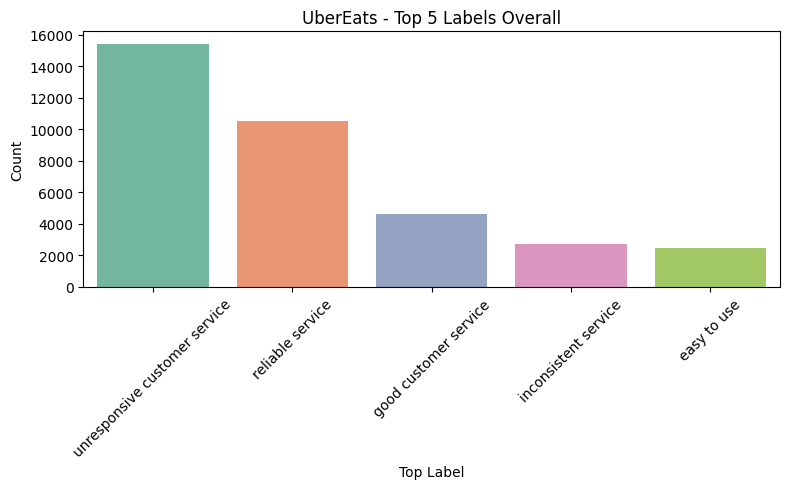

In [15]:
#| echo: true
top5_labels = ubereats['top_label'].value_counts().head(5)

plt.figure(figsize=(8,5))
sns.barplot(x=top5_labels.index, y=top5_labels.values, palette='Set2')
plt.title('UberEats - Top 5 Labels Overall')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


"Unresponsive customer service" is the most frequent concern, with "reliable service" following as a positive counterpoint.
Mixed service perceptions dominate the narrative, showing a polarized customer experience.

## DoorDash - Sentiment - Top 5 Labels

In [16]:
#| echo: true
import plotly.graph_objects as go
import plotly.express as px

# Filter DoorDash data
doordash = combined_df[combined_df['app_name'] == 'DoorDash']
sentiments = ['Positive', 'Neutral', 'Negative']

# Create figure
fig = go.Figure()
buttons = []

# Add one bar trace per sentiment
for idx, sentiment in enumerate(sentiments):
    sentiment_df = doordash[doordash['sentiment'] == sentiment]
    top5 = sentiment_df['top_label'].value_counts().head(5)

    fig.add_trace(go.Bar(
        x=top5.index,
        y=top5.values,
        name=sentiment,
        visible=(idx == 0),  # Show first sentiment by default
        marker_color=px.colors.qualitative.Set2
    ))

# Create dropdown buttons
for i, sentiment in enumerate(sentiments):
    vis = [False] * len(sentiments)
    vis[i] = True
    buttons.append(dict(
        label=sentiment,
        method='update',
        args=[{'visible': vis},
              {'title': f'DoorDash - {sentiment} Sentiment - Top 5 Labels'}]
    ))

# Final layout
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title='DoorDash - Positive Sentiment - Top 5 Labels',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()


## DoorDash - Data Sources - Top 5 Labels

In [17]:
import plotly.graph_objects as go
import plotly.express as px

data_sources = ['Google Play', 'Reddit', 'App Store']
sentiments = ['Positive', 'Neutral', 'Negative']

# Filter DoorDash
doordash = combined_df[combined_df['app_name'] == 'DoorDash']

fig = go.Figure()
buttons = []
trace_labels = []

# Add traces for each data_source + sentiment combination
for ds_idx, data_source in enumerate(data_sources):
    source_df = doordash[doordash['data_source'] == data_source]

    for s_idx, sentiment in enumerate(sentiments):
        df = source_df[source_df['sentiment'] == sentiment]
        top5 = df['top_label'].value_counts().head(5)

        trace = go.Bar(
            x=top5.index,
            y=top5.values,
            name=f'{data_source} - {sentiment}',
            visible=(ds_idx == 0 and s_idx == 0),  # Only first trace is visible initially
            marker_color=px.colors.qualitative.Set2
        )
        fig.add_trace(trace)
        trace_labels.append((data_source, sentiment))

# Create dropdown menu with combined data source + sentiment options
for i, (ds, sentiment) in enumerate(trace_labels):
    vis = [False] * len(trace_labels)
    vis[i] = True
    buttons.append(dict(
        label=f'{ds} - {sentiment}',
        method='update',
        args=[{'visible': vis},
              {'title': f'DoorDash - {ds} - {sentiment} Sentiment - Top 5 Labels'}]
    ))

# Update layout with dropdown
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title='DoorDash - Google Play - Positive Sentiment - Top 5 Labels',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()


## DoorDash - Google Play - Top 5 Labels (All Sentiments)

In [18]:
import plotly.graph_objects as go
import plotly.express as px

# List of data sources
data_sources = ['Google Play', 'Reddit', 'App Store']
fig = go.Figure()
buttons = []

# Loop through each data source and create a trace
for idx, data_source in enumerate(data_sources):
    source_df = doordash[doordash['data_source'] == data_source]
    top5 = source_df['top_label'].value_counts().head(5)

    fig.add_trace(go.Bar(
        x=top5.index,
        y=top5.values,
        name=data_source,
        visible=(idx == 0),
        marker_color=px.colors.qualitative.Set2
    ))

    # Dropdown visibility logic
    visibility = [False] * len(data_sources)
    visibility[idx] = True
    buttons.append(dict(
        label=data_source,
        method='update',
        args=[{'visible': visibility},
              {'title': f'DoorDash - {data_source} - Top 5 Labels (All Sentiments)'}]
    ))

# Set layout and dropdown
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title='DoorDash - Google Play - Top 5 Labels (All Sentiments)',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()


## DoorDash - Overall Top 5 Labels

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\1556962487.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




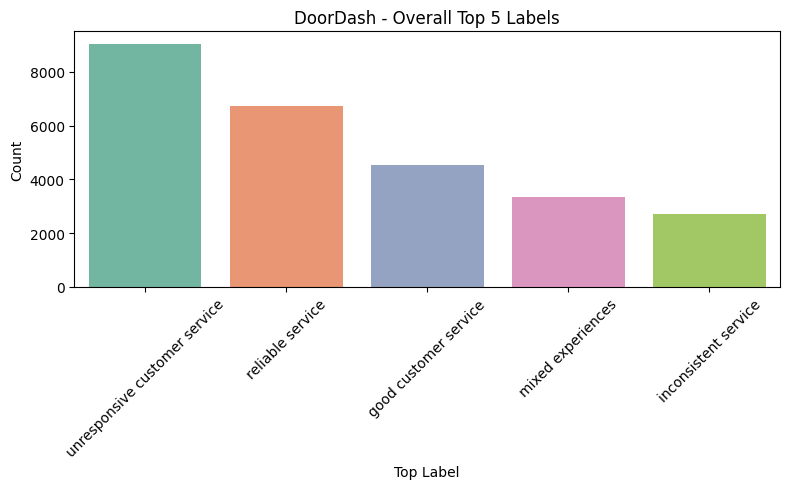

In [19]:
top5_overall = doordash['top_label'].value_counts().head(5)

plt.figure(figsize=(8,5))
sns.barplot(x=top5_overall.index, y=top5_overall.values, palette='Set2')
plt.title('DoorDash - Overall Top 5 Labels')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Similar to UberEats, DoorDash users frequently report "unresponsive customer service" and value "reliable service."
A notable portion of feedback also reflects inconsistency and mixed experiences.

## GrubHub - Sentiment - Top 5 Labels

In [20]:
import plotly.graph_objects as go
import plotly.express as px

# Filter GrubHub data
grubhub = combined_df[combined_df['app_name'] == 'GrubHub']
sentiments = ['Positive', 'Neutral', 'Negative']

# Create figure
fig = go.Figure()
buttons = []

# Add traces for each sentiment
for idx, sentiment in enumerate(sentiments):
    df = grubhub[grubhub['sentiment'] == sentiment]
    top5 = df['top_label'].value_counts().head(5)

    fig.add_trace(go.Bar(
        x=top5.index,
        y=top5.values,
        name=sentiment,
        visible=(idx == 0),
        marker_color=px.colors.qualitative.Set2
    ))

    vis = [False] * len(sentiments)
    vis[idx] = True
    buttons.append(dict(
        label=sentiment,
        method='update',
        args=[
            {'visible': vis},
            {'title': f'GrubHub - {sentiment} Sentiment - Top 5 Labels'}
        ]
    ))

# Layout with dropdown
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title='GrubHub - Positive Sentiment - Top 5 Labels',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()


## GrubHub - Data Sources - Sentiment - Top 5 Labels

In [21]:
import plotly.graph_objects as go
import plotly.express as px

# Prepare
data_sources = ['Google Play', 'Reddit', 'App Store']
sentiments = ['Positive', 'Neutral', 'Negative']
grubhub = combined_df[combined_df['app_name'] == 'GrubHub']

# Create figure and control variables
fig = go.Figure()
buttons = []
trace_labels = []

# Add one trace per (data_source, sentiment) combination
for ds_idx, data_source in enumerate(data_sources):
    source_df = grubhub[grubhub['data_source'] == data_source]

    for s_idx, sentiment in enumerate(sentiments):
        sentiment_df = source_df[source_df['sentiment'] == sentiment]
        top5 = sentiment_df['top_label'].value_counts().head(5)

        fig.add_trace(go.Bar(
            x=top5.index,
            y=top5.values,
            name=f'{data_source} - {sentiment}',
            visible=(ds_idx == 0 and s_idx == 0),  # Only first trace visible by default
            marker_color=px.colors.qualitative.Set2
        ))

        trace_labels.append((data_source, sentiment))

# Create dropdown buttons
for i, (ds, sentiment) in enumerate(trace_labels):
    vis = [False] * len(trace_labels)
    vis[i] = True
    buttons.append(dict(
        label=f'{ds} - {sentiment}',
        method='update',
        args=[
            {'visible': vis},
            {'title': f'GrubHub - {ds} - {sentiment} Sentiment - Top 5 Labels'}
        ]
    ))

# Layout and dropdown
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title='GrubHub - Google Play - Positive Sentiment - Top 5 Labels',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()

## GrubHub - Data_Source - Top 5 Labels (All Sentiments)

In [22]:
import plotly.graph_objects as go
import plotly.express as px

# Filter for GrubHub
grubhub = combined_df[combined_df['app_name'] == 'GrubHub']
data_sources = ['Google Play', 'Reddit', 'App Store']

# Create the figure
fig = go.Figure()
buttons = []

# Add one trace per data source
for idx, data_source in enumerate(data_sources):
    source_df = grubhub[grubhub['data_source'] == data_source]
    top5 = source_df['top_label'].value_counts().head(5)

    fig.add_trace(go.Bar(
        x=top5.index,
        y=top5.values,
        name=data_source,
        visible=(idx == 0),
        marker_color=px.colors.qualitative.Set2
    ))

    # Set visibility for dropdown
    visibility = [False] * len(data_sources)
    visibility[idx] = True

    buttons.append(dict(
        label=data_source,
        method='update',
        args=[
            {'visible': visibility},
            {'title': f'GrubHub - {data_source} - Top 5 Labels (All Sentiments)'}
        ]
    ))

# Final layout with dropdown
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title='GrubHub - Google Play - Top 5 Labels (All Sentiments)',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()


## GrubHub - Overall Top 5 Labels

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\3418218262.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




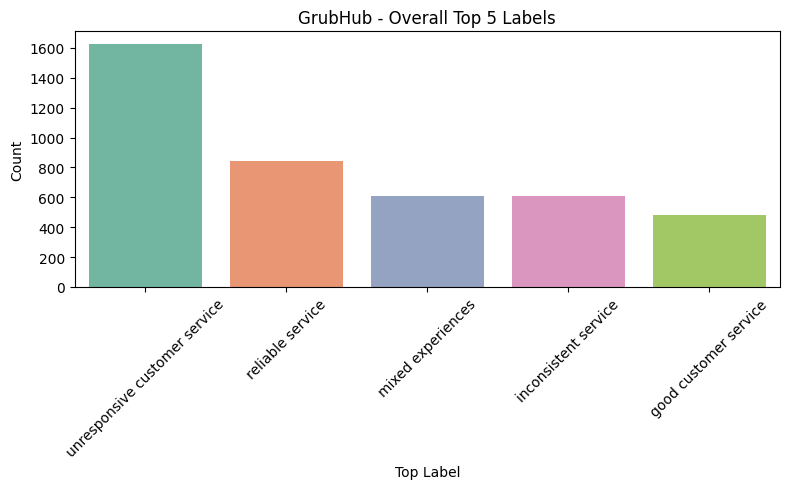

In [23]:
top5_overall = grubhub['top_label'].value_counts().head(5)

plt.figure(figsize=(8,5))
sns.barplot(x=top5_overall.index, y=top5_overall.values, palette='Set2')
plt.title('GrubHub - Overall Top 5 Labels')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


GrubHub shares similar patterns with its competitors—customer service issues top the list.
"Reliable service" and "mixed experiences" suggest a divided but slightly less vocal user base.

## Google Play - Sentiment - Top 5 Labels

In [24]:
import plotly.graph_objects as go
import plotly.express as px

# Filter for Google Play
google_play = combined_df[combined_df['data_source'] == 'Google Play']
sentiments = ['Positive', 'Neutral', 'Negative']

# Create figure and dropdown buttons
fig = go.Figure()
buttons = []

# Add traces for each sentiment
for idx, sentiment in enumerate(sentiments):
    sentiment_df = google_play[google_play['sentiment'] == sentiment]
    top5 = sentiment_df['top_label'].value_counts().head(5)

    fig.add_trace(go.Bar(
        x=top5.index,
        y=top5.values,
        name=sentiment,
        visible=(idx == 0),  # Only show first by default
        marker_color=px.colors.qualitative.Set2
    ))

    visibility = [False] * len(sentiments)
    visibility[idx] = True

    buttons.append(dict(
        label=sentiment,
        method='update',
        args=[
            {'visible': visibility},
            {'title': f'Google Play - {sentiment} Sentiment - Top 5 Labels'}
        ]
    ))

# Final layout with dropdown
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title='Google Play - Positive Sentiment - Top 5 Labels',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()


## Google Play - Overall Top 5 Labels (All Sentiments)

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\3286387572.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




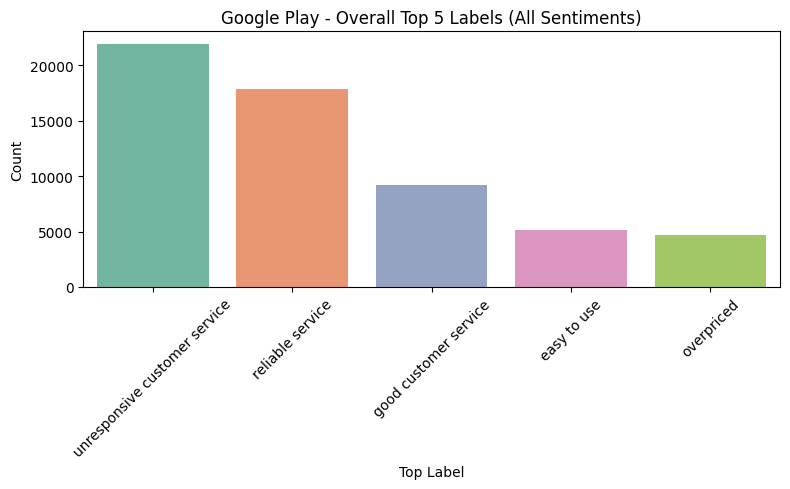

In [25]:
top5_gp_all = google_play['top_label'].value_counts().head(5)

plt.figure(figsize=(8,5))
sns.barplot(x=top5_gp_all.index, y=top5_gp_all.values, palette='Set2')
plt.title('Google Play - Overall Top 5 Labels (All Sentiments)')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


On Google Play, feedback on customer service is most dominant, both negatively ("unresponsive") and positively ("good").
Usability ("easy to use") and pricing also influence customer sentiment significantly.

## Reddit - Sentiment - Top 5 Labels

In [26]:
import plotly.graph_objects as go
import plotly.express as px

# Filter for Reddit
reddit = combined_df[combined_df['data_source'] == 'Reddit']
sentiments = ['Positive', 'Neutral', 'Negative']

# Initialize figure and dropdown configuration
fig = go.Figure()
buttons = []

# Add a bar trace for each sentiment
for idx, sentiment in enumerate(sentiments):
    sentiment_df = reddit[reddit['sentiment'] == sentiment]
    top5 = sentiment_df['top_label'].value_counts().head(5)

    fig.add_trace(go.Bar(
        x=top5.index,
        y=top5.values,
        name=sentiment,
        visible=(idx == 0),  # Show only the first one initially
        marker_color=px.colors.qualitative.Set2
    ))

    visibility = [False] * len(sentiments)
    visibility[idx] = True

    buttons.append(dict(
        label=sentiment,
        method='update',
        args=[
            {'visible': visibility},
            {'title': f'Reddit - {sentiment} Sentiment - Top 5 Labels'}
        ]
    ))

# Layout configuration
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title='Reddit - Positive Sentiment - Top 5 Labels',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()


## Reddit - Overall Top 5 Labels (All Sentiments)

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\1014653831.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




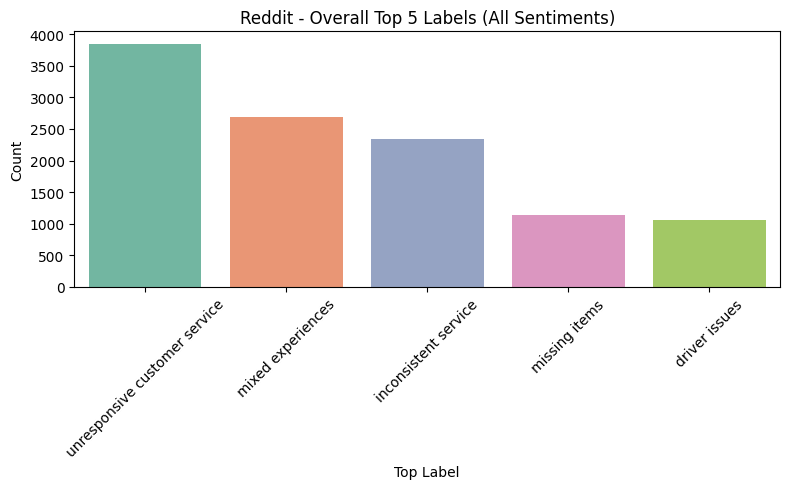

In [27]:
top5_reddit_all = reddit['top_label'].value_counts().head(5)

plt.figure(figsize=(8,5))
sns.barplot(x=top5_reddit_all.index, y=top5_reddit_all.values, palette='Set2')
plt.title('Reddit - Overall Top 5 Labels (All Sentiments)')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Reddit discussions heavily critique customer service, followed by comments on inconsistent and mixed experiences.
Issues like missing items and driver problems highlight operational gaps.

## App Store - Sentiment - Top 5 Labels

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# Filter App Store data
app_store = combined_df[combined_df['data_source'] == 'App Store']
sentiments = ['Positive', 'Neutral', 'Negative']

# Create figure and dropdown config
fig = go.Figure()
buttons = []

# Add traces for each sentiment
for idx, sentiment in enumerate(sentiments):
    sentiment_df = app_store[app_store['sentiment'] == sentiment]
    top5 = sentiment_df['top_label'].value_counts().head(5)

    fig.add_trace(go.Bar(
        x=top5.index,
        y=top5.values,
        name=sentiment,
        visible=(idx == 0),  # Show only the first by default
        marker_color=px.colors.qualitative.Set2
    ))

    visibility = [False] * len(sentiments)
    visibility[idx] = True

    buttons.append(dict(
        label=sentiment,
        method='update',
        args=[
            {'visible': visibility},
            {'title': f'App Store - {sentiment} Sentiment - Top 5 Labels'}
        ]
    ))

# Final layout
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction='down',
        showactive=True,
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title='App Store - Positive Sentiment - Top 5 Labels',
    xaxis_title='Top Label',
    yaxis_title='Count'
)

fig.show()


## App Store - Overall Top 5 Labels (All Sentiments)

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\1882811874.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




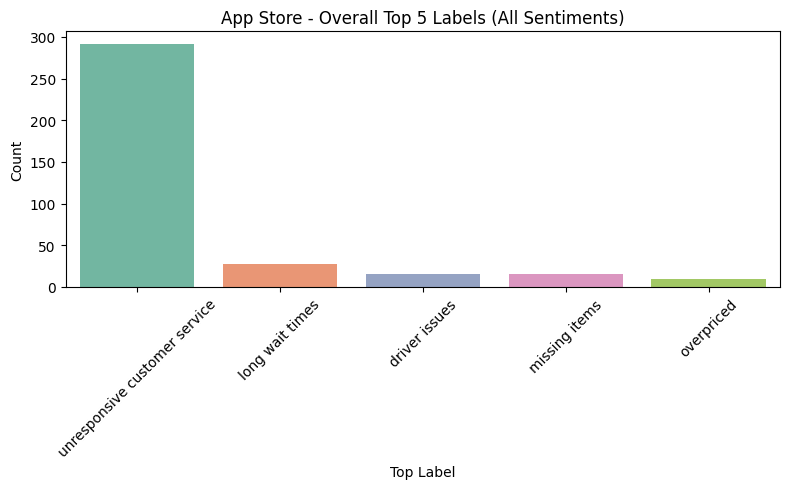

In [29]:
top5_appstore_all = app_store['top_label'].value_counts().head(5)

plt.figure(figsize=(8,5))
sns.barplot(x=top5_appstore_all.index, y=top5_appstore_all.values, palette='Set2')
plt.title('App Store - Overall Top 5 Labels (All Sentiments)')
plt.xlabel('Top Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


"Unresponsive customer service" overwhelmingly dominates App Store feedback.
Other concerns like long wait times and delivery issues appear far less frequently, indicating focused dissatisfaction.

# Top Label Frequency Over Time (All Apps & Platforms)

C:\Users\chira\AppData\Local\Temp\ipykernel_11780\3157324320.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



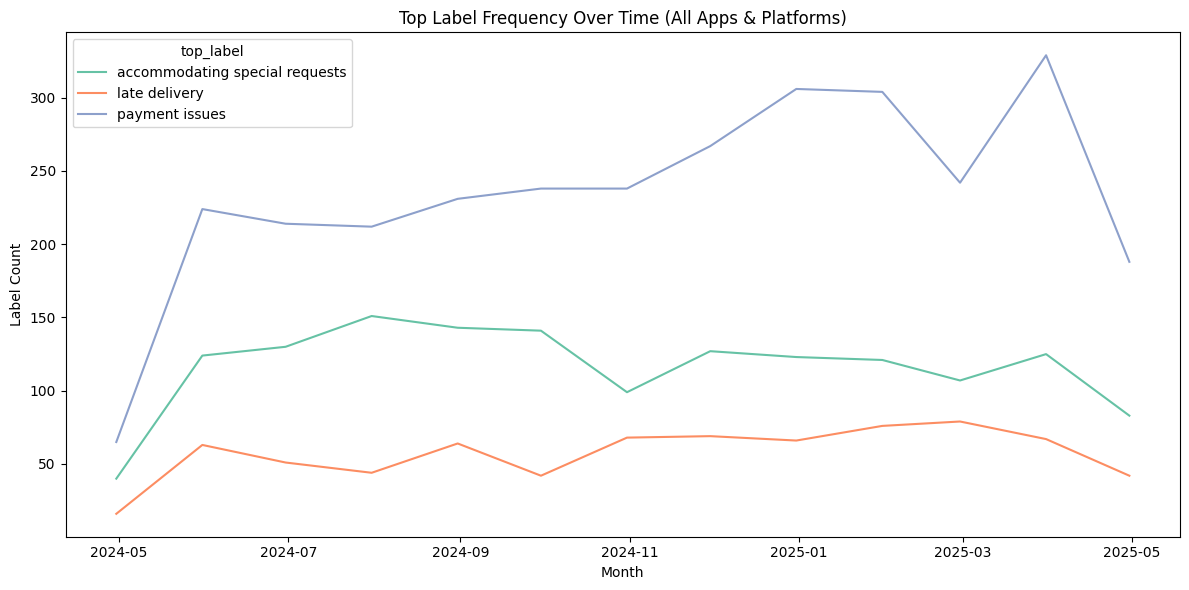

In [30]:
combined_df['review_datetime'] = pd.to_datetime(combined_df['review_datetime'], errors='coerce')
top_label_trend = combined_df.groupby([pd.Grouper(key='review_datetime', freq='M'), 'top_label']).size().reset_index(name='count')

# Plot top 3 labels over time
top_labels = top_label_trend['top_label'].value_counts().index[:3]
trend_subset = top_label_trend[top_label_trend['top_label'].isin(top_labels)]

plt.figure(figsize=(12,6))
sns.lineplot(data=trend_subset, x='review_datetime', y='count', hue='top_label', palette='Set2')
plt.title('Top Label Frequency Over Time (All Apps & Platforms)')
plt.xlabel('Month')
plt.ylabel('Label Count')
plt.tight_layout()
plt.show()


"Unresponsive customer service" overwhelmingly dominates App Store feedback.
Other concerns like long wait times and delivery issues appear far less frequently, indicating focused dissatisfaction.